In [1]:
import os
import sys
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import pandas as pd
import math
import argparse
import errno
import json
from IPython.display import display
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
IMG_DIR = '/vol/vssp/cvpnobackup_orig/scratch_4weeks/tb0035/projects/content_prov/data/psbattles_public'
TRAIN_LST = '/vol/vssp/cvpnobackup_orig/scratch_4weeks/tb0035/projects/content_prov/data/psbattles_public/train_pairs.csv'
TEST_LST = '/vol/vssp/cvpnobackup_orig/scratch_4weeks/tb0035/projects/content_prov/data/psbattles_public/test_pairs.csv'
MTURK = ['/vol/vssp/cvpnobackup_orig/scratch_4weeks/tb0035/projects/content_prov/data/psbattles/mturk_res/tu_1.csv',
         '/vol/vssp/cvpnobackup_orig/scratch_4weeks/tb0035/projects/content_prov/data/psbattles/mturk_res/tu_2.csv',
         '/vol/vssp/cvpnobackup_orig/scratch_4weeks/tb0035/projects/content_prov/data/psbattles/mturk_res/tu_3.csv']
colors = ['red', 'green', 'blue', 'magenta', 'cyan', 'yellow']

test_df = pd.read_csv(TEST_LST)
res = pd.concat([pd.read_csv(mturk) for mturk in MTURK], ignore_index=True)

In [3]:
def convert_annotation(org_size, pho_size, m_size, ann):
    """convert mturk annotation to bounding box matching original size
    org_size, pho_size, m_size are size of original, photoshop images in PSBattles and joint image shown to turker.
        Each is a tuple of (x,y) format corresponding to width and height.
    ann is mturk bounding box annotation, a tuple of format (x, y, w, h) correspond to (left, top, width, height)
    
    Output: (ann_out, which) where ann_out is annotation wrt natural size, which is 1 if original image is annotated,
        otherwise 0
    """
    ## forward pass
    wo, ho = org_size
    wp, hp = pho_size
    # phase 1: resize photoshop
    r = ho/hp
    wp1, hp1 = int(r*wp), ho
    # phase 2: concat
    w2, h2 = wo + wp1, ho
    # phase 3: resize to fixed width of 800
    g = 800/w2
    w3, h3 = 800, int(h2 * g)
    # phase 4: pad text
    w4, h4 = w3, h3+20
    
    ## backward pass
    wa, ha = m_size  # mturk image size, should directly correspond to w4,h4
    # back phase 4
    a4 = (ann[0] * w4/wa, ann[1] * h4/ha, ann[2]*w4/wa, ann[3] * h4/ha)
    # back phase 3
    top = min(a4[1],h3)
    a3 = (a4[0], top, a4[2], min(a4[3] + top,h3) - top)
    # back phase 2
    a2 = (a3[0] * w2/w3, a3[1] * h2/h3, a3[2] * w2/w3, a3[3] * h2/h3)
    # back phase 1
    if a2[0] > wo:  # annotation on photoshop
        a1 = (a2[0] - wo, a2[1], a2[2], a2[3])
        which = 0
        ann_out = (a1[0] * wp/wp1, a1[1] * hp/hp1, a1[2] * wp/wp1, a1[3]*hp/hp1)
    else:  # annotation on original
        print('Rare case: annotation on original')
        assert a2[0] + a2[2] <= wo, 'Error bounding box covers both images'
        ann_out = a2
        which = 1
    return ann_out, which

In [4]:
# take an example of original-photoshop pair
ind = 100
org_path = test_df['original'][ind]
pho_path = test_df['photoshop'][ind]
print(f'Original path {org_path}, photoshop path {pho_path}')
pho_name = pho_path.split('/')[-1]

# mturk results
match_df = res[res['Input.photoshop'] == pho_name]
annotations = [json.loads(ann) for ann in match_df['Answer.annotatedResult.boundingBoxes']]
print(f'This task got annotations from {len(annotations)} mturkers')

Original path originals/5mxu1m.jpg, photoshop path photoshops/5mxu1m/dc75m47_0.jpg
This task got annotations from 3 mturkers


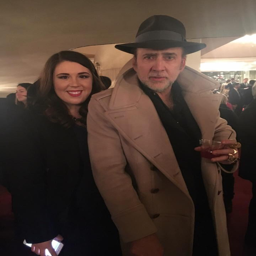

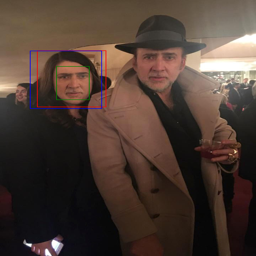

In [5]:
org = Image.open(os.path.join(IMG_DIR, org_path)).convert('RGB')
pho = Image.open(os.path.join(IMG_DIR, pho_path)).convert('RGB')
mturk_size = (match_df['Answer.annotatedResult.inputImageProperties.width'].iloc[0], match_df['Answer.annotatedResult.inputImageProperties.height'].iloc[0])
ann_out = []
for mturk_ann in annotations:  # iterate mturkers
    boxes = []
    for m in mturk_ann:  # iterate annotations from each turker
        box, original_ann = convert_annotation((org.width, org.height), (pho.width, pho.height), mturk_size, (m['left'], m['top'], m['width'], m['height']))
        if not original_ann:
            boxes.append(box)
    ann_out.append(boxes)

# visualize
draw = ImageDraw.Draw(pho)
for i, boxes in enumerate(ann_out):
    for box in boxes:
        xy = [(box[0], box[1]), (box[0] + box[2], box[1] + box[3])]
        draw.rectangle(xy, outline=colors[i], width=2)
display(org.resize((256,256)))
display(pho.resize((256,256)))